In [26]:
%matplotlib inline     
import random 
import torch
from d2l import torch as d2l
# %matplotlib inline  可以内嵌画图，省略掉plt.show()这一步 

生成数据集

In [27]:
def synthetic_data(w,b,num_examples):     # 用于合成数据：围绕真实的w,b进行生成用于训练的数据
    """生成y = Xw + b + 噪声"""
    X = torch.normal(0,1,(num_examples,len(w)))   #生成正态分布是吗？？？
    y = torch.matmul(X,w) + b      # X * w  + b
    y += torch.normal(0,0.01,y.shape)
    return X,y.reshape((-1,1))     # y.reshape((-1,1))将数据转化为1列？？ 

In [28]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w,true_b,1000)

In [29]:
print('features:',features[0],'\nlabel:',labels[0])

features: tensor([-0.9553,  0.5031]) 
label: tensor([0.5812])


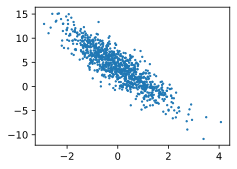

In [30]:
d2l.set_figsize()
d2l.plt.scatter(features[:,(1)].detach().numpy(),labels.detach().numpy(),2)

In [31]:
def data_iter(batch_size,features,labels):    # 接受 批量大小 (一次训练所抓取的样本的数量)，特征矩阵，标签的向量
    num_examples = len(features)
    indices= list(range(num_examples))        # 获取下表的列表
    # 做到随机读取
    random.shuffle(indices)                   # 将这个list中的元素打乱
    for i in range(0,num_examples,batch_size):   
        batch_indices = torch.tensor(indices[i:min(i + batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]


In [32]:
batch_size = 10    #设置批量的大小

for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break          #设置打印出来第一行这个

tensor([[ 0.1112, -1.0952],
        [ 1.1239,  0.4475],
        [ 1.2723,  0.3981],
        [-1.7120,  0.3391],
        [ 1.0804, -2.2381],
        [-0.0642,  0.2152],
        [-0.3374, -0.4309],
        [-0.5349, -0.3567],
        [-0.2869, -0.0547],
        [ 2.6166,  0.9674]]) 
 tensor([[ 8.1288],
        [ 4.9252],
        [ 5.3957],
        [-0.3770],
        [13.9665],
        [ 3.3328],
        [ 4.9904],
        [ 4.3451],
        [ 3.8104],
        [ 6.1369]])


 **小批量梯度下降(Mini-batch Gradient Descent，MBGD)**

In [33]:
# 线性回归模型的定义
def linreg(X,w,b):    #@save 表示在d2l包中是含有这个函数的
    """线性回归的模型"""
    return torch.matmul(X,w) + b 

这里均方误差的公式为$\frac{(\hat{y} - y)^2}{2}$

In [34]:
def squared_loss(y_hat,y): #@save
    """均方误差"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

对于MBGD的定义

In [35]:
# 定义优化器
def sgd(params,lr,batch_size):
    """小批量梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size     # 参数的方向是梯度的反方向
            # param -= lr * param.grad
            param.grad.zero_() 

**开始训练！**

每次迭代中，读取一小批量的训练样本，然后通过我们的模型来得到一组预测


计算完损失之后，开始反向地传播，存储每个参数的梯度，然后再调用优化算法来获得一组预测值

In [36]:
### 对于参数的定义！！！    ###
# 从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，并将偏置初始化为0。
# 什么是偏置 -- b = 0
w = torch.normal(0,0.01,size = (2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)
# 得到这些参数之后就去改变这些参数，直到这些参数可以很好地拟合数据
# 反向传播就是自动求导的过程
# 在整个迭代周期中个数num_epochs和学习率lr都是超参数
lr = 0.03
num_epochs = 10          # 第三次就可以达到一个效果
net = linreg             # 这里直接就写了一个函数名是什么意思？
loss = squared_loss

In [37]:
for epoch in range(num_epochs):     # 在总的步长中的每个步长
    for X,y in data_iter(batch_size,features,labels):
        # 这里的net就是把X,w,b等参数送到net中，得到模型的预估值
        l = loss(net(X,w,b),y)      # 计算x和y的批量损失
        # l的形状是(batch_size，1)，不是一个标量
        # l.sum().backward()
        l.sum().backward()
        sgd([w,b],lr,batch_size)   # 使用参数的梯度来更新参数
    with torch.no_grad():          # 所有计算出来的tensor的require_grad都自动设置为False,可以减少内存
        train_1 = loss(net(features,w,b),labels)
        print(f'epoch{epoch+1},loss{float(train_1.mean()):f}')

epoch1,loss0.042351
epoch2,loss0.000170
epoch3,loss0.000053
epoch4,loss0.000053
epoch5,loss0.000053
epoch6,loss0.000053
epoch7,loss0.000053
epoch8,loss0.000053
epoch9,loss0.000053
epoch10,loss0.000053


In [17]:
print(f'w的估计误差:{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差:{true_b - b}')

w的估计误差:tensor([ 7.1883e-05, -4.0078e-04], grad_fn=<SubBackward0>)
b的估计误差:tensor([0.0004], grad_fn=<RsubBackward1>)


In [38]:
print("W",w)
print("b",b)

W tensor([[ 2.0001],
        [-3.3992]], requires_grad=True)
b tensor([4.1996], requires_grad=True)


通过$Pytorch$实现线性回归

In [39]:
# 共用上面的样本
labels, features

(tensor([[ 5.8123e-01],
         [-1.8170e+00],
         [ 2.2058e+00],
         [ 5.7694e+00],
         [ 1.3744e-01],
         [ 1.8975e-01],
         [ 9.2556e+00],
         [ 6.5012e+00],
         [ 6.9576e+00],
         [-6.2394e-02],
         [ 1.7755e+00],
         [ 8.0815e+00],
         [ 7.7786e+00],
         [ 5.8949e+00],
         [ 1.4941e+00],
         [ 6.2225e-01],
         [-1.2969e+00],
         [-3.5616e+00],
         [-1.2557e+00],
         [ 2.5970e+00],
         [-2.6311e+00],
         [ 6.3274e+00],
         [ 8.5969e+00],
         [ 6.8742e+00],
         [ 5.9474e-01],
         [ 1.3581e+00],
         [ 2.9219e+00],
         [-1.7646e-01],
         [ 4.2115e+00],
         [ 8.9648e+00],
         [-2.3281e+00],
         [ 4.2817e+00],
         [ 1.2753e+01],
         [-4.7489e-01],
         [ 6.0427e+00],
         [ 8.1505e+00],
         [ 4.4291e+00],
         [ 6.3885e+00],
         [-1.5211e+00],
         [-2.3631e+00],
         [ 3.2929e+00],
         [ 4.593

**简洁实现**

In [40]:
import pandas as pd
import torch
from torch.utils import data
from torch import nn

In [ ]:
# 构造一个Dataloader(不仅可以采样数据，还可以高效的处理，读取数据)
